In [1]:
import numpy as np
import pysindy as ps
from scipy.integrate import odeint, solve_ivp

import matplotlib.pyplot as plt
from math import pi

In [2]:
def validate(x_or, t_or, model, cond_inic):
    x_test_sim = model.simulate(cond_inic, t_or)
    print('Model score: %f' % model.score(x_test_sim, t=t[1]-t[0]))
    fig, axs = plt.subplots(x_or.shape[1], 1, sharex=True, figsize=(5, 6), squeeze=False)
    for i in range(x_or.shape[1]):
        axs[i, 0].plot(t_or, x_or[:, i], 'k', label='true simulation')
        axs[i, 0].plot(t_or, x_test_sim[:, i], 'r--', label='model simulation')
        axs[i, 0].legend()
        axs[i, 0].set(xlabel='t', ylabel='$x_{}$'.format(i))
    return x_test_sim   

## Vuelo rectilíneo y simétrico: T cte y V variable y grande

- Vuelo rectilíneo, simétrico , alas a nivel no estacionario
- Dos ecuaciones dinámicas, dos incógnitas: V y cl
- Sustiuimos el valor del cl en la ec en eje x y queda una ecuación con una incógnita, la velocidad
- Este caso simula velocidades grandes por lo que los términos 1/v^2 se consideran despreciables
$$
L = W \\
-D + T = m\dot{V} \\
D = \frac{1}{2} \rho_{aire} V^{2} S C_{D0} + k \frac{W^2}{\frac{1}{2} \rho_{aire} V^{2} S} \\
\frac{T}{m} - \frac{1}{2} \rho_{aire} V^{2} \frac{S}{m} C_{D0} - k \frac{g^2}{\frac{1}{2} \rho_{aire} V^{2} \frac{S}{m}} = \dot{V}
$$

Sindy será alimentado con la velocidad adimensionalizada, por tanto las ecuaciones son las siguientes:
$$
\dot{V} = -AV^2 + C \\
\hat{V} = \frac{V}{U_\infty} \\
Por\hspace{0.1cm}tanto:\hspace{0.1cm}
\hat{\dot{V}} = \frac{dV}{dt}\frac{1}{U_\infty} \\
Se\hspace{0.1cm}obtiene:\hspace{0.1cm}
U_\infty \hat{\dot{V}} = -AU_\infty^2\hat{V}^2 + C \\

Despejando:\hspace{0.1cm}
\hat{\dot{V}} = -AU_\infty \hat{V}^2 + \frac{C}{U_\infty}\\
A = \frac{1}{2} \rho_{aire} \frac{S}{m} C_{D0}; C = \frac{T}{m}
$$
Sindy calcula los coeficientes a y c:
$$ a = AU_\infty; c = \frac{C}{U_\infty}\\ $$
$$\hat{\dot{V}} = -a{\hat{V}}^2 + c \\$$

In [3]:
#definición de las variables generales
n = 10000
deltat = 0.001
t = np.zeros(n+1)
for i in range(1, n+1):
    t[i] = deltat*i

print(t.shape[0], t)

10001 [0.000e+00 1.000e-03 2.000e-03 ... 9.998e+00 9.999e+00 1.000e+01]


In [4]:
# definicion de parametros fisicos y aerodinamicos de la aeronave:
# tomado de http://www.aero.us.es/iia/archivos/Problemas/Problemas_MV.pdf
m = 200
W = m*9.81
vx0 = 10
S = 14.7
cd0 = 0.03
k = 0.073
T0 = 12 # T/m
A = 0.5*1.225*cd0*S/m
B = k*9.81**2/(0.5*1.225*S/m)
print(f"Valor de los coeficientes: A={A}, C={T0}")

Valor de los coeficientes: A=0.0013505625, C=12


In [5]:
# la vel de L y D  es la del eje x y no es cte
def create_data_dim_ecs(t, vx0, T0=T0, A=A, B=B):
    n = t.shape[0]
    deltat = t[1]-t[0]

    vx = np.zeros(n)
    vx[0] = vx0

    T = T0 * np.ones(n) #en realidad esto es T/m no el empuje
    

    for i in range(1, n):
        vx[i] = vx[i - 1] + deltat * (T[i-1]-A*vx[i-1]**2-B/vx[i-1]**2*0)

    return vx

In [6]:
#condiciones iniciales generadas para cada trayectoria:
n_trayec = 5
vx0 = np.ones(n_trayec)


for i in range(n_trayec):
    vx0[i] = np.random.uniform(low=10, high=100)

vx0[0] = 100
"""
vx0[1] = 20
vx0[2] = 30
vx0[3] = 40
vx0[4] = 50
"""


'\nvx0[1] = 20\nvx0[2] = 30\nvx0[3] = 40\nvx0[4] = 50\n'

In [7]:
# creo cada trayectoria llamandado a create_glider_data
#las trayectorias son filas mientras que las columnas son caracterisitcas
data1 = []

for i in range(n_trayec):
    data1.append(create_data_dim_ecs(t, vx0[i]))

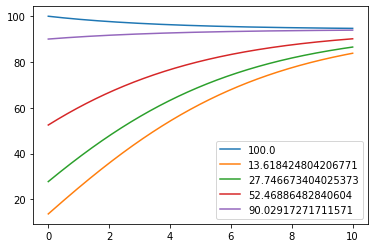

In [8]:
#plot de la velocidad de cada trayectoria
plt.figure()
for i in range(n_trayec):
    a = data1[i]
    plt.plot(t, a[:], label=str(vx0[i])) 

plt.legend()

In [9]:
#adimensionalizo buscando el maximo por caracteristica para todas las trayectorias
data1_adim = []
maxi = np.max(data1, axis=1)
maxi = np.max(maxi, axis=0)
for i in range(n_trayec):
    data1_adim.append(data1[i] / maxi)
#print(len(data1_adim), data1_adim[0].shape)

In [10]:
maxi = np.max(data1, axis=1)
np.max(maxi, axis=0)

100.0

In [11]:
def custom_ecs_dim():
    library_functions = [
        lambda v : v**2,
        lambda v: 1/v**2,
        lambda t: 1
    ]
    library_function_names = [
        lambda v : v + "^2",
        lambda v: '1/' + v + "^2", 
        lambda t: "1"
    ]
    library = ps.CustomLibrary(library_functions=library_functions, function_names=library_function_names,
                              interaction_only=True)
    return library

In [12]:
# creo un initial guess para que la primera solucion que encuentre no sea la de todas las ecuaciones = 0
#uso un reshape por el caso de tener un array, pues no tiene dimension de columnas, es posicional

print(data1[0].shape, data1[0].reshape(-1, 1).shape)
lib = custom_ecs_dim().fit(data1[0].reshape(-1, 1))
n_features = lib.n_output_features_
initial_guess = np.ones((data1[0].reshape(-1, 1).shape[1], n_features))

initial_guess[0, 0] = 32
initial_guess[0, 1] =  40
initial_guess[0, 2] =  -np.pi

print(data1[0].reshape(-1, 1).shape[1], n_features)


(10001,) (10001, 1)
1 3


In [13]:
model = ps.SINDy(
        #differentiation_method=ps.SINDyDerivative(kind='finite_difference', k=1),
        optimizer=ps.SR3(), #initial_guess=initial_guess
        feature_library=custom_ecs_dim(),
        ##ps.PolynomialLibrary(degree=2)#interaction_only=terminos_ctes,
                                                         
        feature_names=['vx'], #'x', 'y', 'v', 'alfa', 'theta', "theta'"
    )

#la doc dice que en t hay que poner el time step
model.fit(data1_adim, t=deltat, multiple_trajectories=True) #

#print(model.equations(precision=52))
model.print(precision=4)

(vx)' = -0.1351 vx^2 + 0.1200 1


In [14]:
model.get_feature_names()
print(f"Valor de los coeficientes: A={A}, C={T0}")
print(f"Valor de los coeficientes que sindy debe obtenr: A={A*maxi[0]}, C=T0={T0/maxi[0]}")

Valor de los coeficientes: A=0.0013505625, C=12
Valor de los coeficientes que sindy debe obtenr: A=0.13505625, C=T0=0.12


Error: 6.750231219061886e-13
Error in last point: 2.2412053363691825e-16


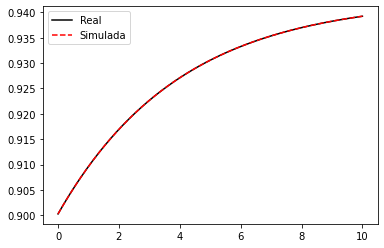

In [17]:
#dibujo la ec de sindy para ver si son correctas con datos de train
x_sim = model.simulate([data1_adim[4][0]], t)
print(f"Error: {((x_sim.squeeze()-data1_adim[4])**2).sum() / n}")
print(f"Error in last point: {((x_sim[-1]-data1_adim[4][-1])**2).sum() / n}")

#ploteo los datos para ver las trayectorias
plt.figure()

plt.plot(t, data1_adim[4], 'k', label='Real') 
plt.plot(t, x_sim[:, 0], 'r--', label='Simulada')
plt.legend()

In [16]:
#dibujo la ec de sindy para ver si son correctas con datos de train
v0 = 5
x_sim = model.simulate(v0/maxi[0], t)
x_real = create_data_dim_ecs(t, v0)/maxi[0]
#ploteo los datos para ver las trayectorias
plt.figure()

plt.plot(t, x_real.T, 'k', label='Real') 
plt.plot(t, x_sim, 'r--', label='Simulada')
plt.legend()

print(f"Error: {((x_sim.squeeze()*maxi[0]-x_real.T)**2).sum() / n}")
print(f"Error in last point: {((x_sim[-1]*maxi[0]-x_real.T[-1])**2).sum() / n}")

ValueError: `y0` must be 1-dimensional.

$$
En\hspace{0.1cm} este\hspace{0.1cm}caso:
a = 0.1351 = AU_\infty, A = \frac{0.1351}{100} = 0.001351\\
c = 0.12 = \frac{C}{U_\infty}, C = 0.12*100 = 12\\
$$

Como se puede ver hace un ajuste perfecto de los coeficientes

/home/mdiaz/.local/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


array([[0.00000000e+00],
       [3.03418171e-11],
       [1.21365158e-10],
       ...,
       [4.84514276e-04],
       [4.84489900e-04],
       [4.84465518e-04]])

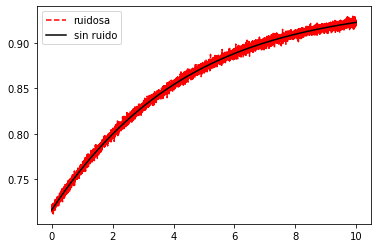

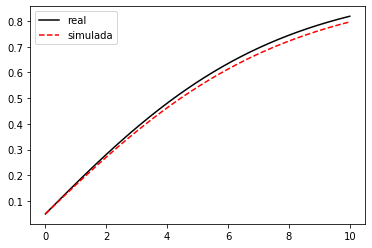

In [ ]:
import utils
data, data_dot, lib_custom, data_val = utils.casoB(4, t, [T0, A, B], t, 5)

data_adim, data_val_adim, data_adim_dot = utils.adimensionalizar(data, 4, data_val, data_dot, 0.00001, 
                                                        0, t, True, True)
utils.eval(utils.casoB, 4, t, [T0, A, B], 5, ruido=0.001, plot_traj=True)

## Vuelo rectilíneo y simétrico: T cte y V variable y pequeña

Lo que sindy en realidad está viendo:
$$
U_\infty \hat{\dot{V}} = -AU_\infty^2\hat{V^2} + C - \frac{B}{\hat{V}^2*U_\infty^2}\\
\hat{\dot{V}} = -AU_\infty\hat{V^2} + \frac{C}{U_\infty} - \frac{B}{\hat{V}^2*U_\infty^3}\\
A = \frac{1}{2} \rho_{aire} \frac{S}{m} C_{D0} \\
B = k \frac{g^2}{\frac{1}{2} \rho_{aire} \frac{S}{m}}\\
C = \frac{T}{m} \\
Sindy\hspace{0.1cm} calcula:
a = AU_\infty \\
b = \frac{B}{U_\infty^3}\\
c = \frac{C}{U_\infty}\\
\hat{\dot{V}} = -a\hat{V}^2 + c - \frac{b}{\hat{V}^2}\\
$$


### Integrador solve_ivp

In [3]:
#definición de las variables generales
n = 100000
deltat = 0.00001
t = np.zeros(n+1)
for i in range(1, n+1):
    t[i] = deltat*i

print(t.shape[0], t)


100001 [0.0000e+00 1.0000e-05 2.0000e-05 ... 9.9998e-01 9.9999e-01 1.0000e+00]


In [16]:
# definicion de parametros fisicos y aerodinamicos de la aeronave
m = 200
W = m*9.81
vx0 = 10
S = 14.7
cd0 = 0.03
k = 0.073
vmax = 6

#multiplico por 10 porque si no es un valor tan pequeño que no lo va ver
A = 0.5*1.225*cd0*S/m*10
B = k*9.81**2/(0.5*1.225*S/m)
# Este es el coeficiete C, en realidad es T/m
T0 = 7
print(f"Valor de los coeficientes: A={A}, B={B}, C={T0}")


Valor de los coeficientes: A=0.013505625, B=156.0513186172428, C=7


In [17]:
#defino la funcion a resolver por el solver:
def ecs_dot(t, y, T0, A, B):
    vx = y
    return T0 - A*vx**2 - B/vx**2

In [18]:
#condiciones iniciales generadas para cada trayectoria:
n_trayec = 100
vx0 = np.ones(n_trayec)


for i in range(n_trayec):
    vx0[i] = np.random.uniform(low=5, high=5.5)
    #vx0[i] = np.random.uniform(low=5, high=100)

    
#vx0[3] = 10
#vx0[2] = 0.1

"""
vx0[1] = 20
vx0[2] = 30
vx0[3] = 40
vx0[4] = 50
"""


'\nvx0[1] = 20\nvx0[2] = 30\nvx0[3] = 40\nvx0[4] = 50\n'

In [19]:
# creo cada trayectoria llamandado a create_glider_data
#las trayectorias son filas mientras que las columnas son caracterisitcas
data2 = []
coefs = [T0, A, B]
for i in range(n_trayec):
    vx_sol = solve_ivp(ecs_dot, (t[0], t[-1]), [vx0[i]], args=(coefs), t_eval=t)
    data2.append(vx_sol.y.T)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


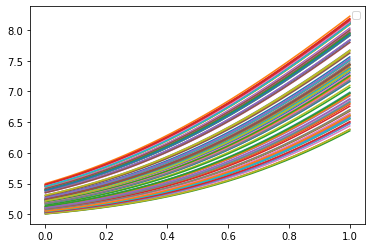

In [20]:
#ploteo los datos para ver la velocidad de cada trayectoria
plt.figure()
for i in range(n_trayec):
    a = data2[i]
    plt.plot(t, a[:]) #, label=str(data2[i][0])

plt.legend()

In [21]:
#adimensionalizo buscando el maximo por caracteristica para todas las trayectorias
data2_adim = []
maxi = np.max(data2, axis=1)
maxi = np.max(maxi, axis=0)
for i in range(n_trayec):
    data2_adim.append(data2[i] / maxi)
#print(len(data1_adim), data1_adim[0].shape)

In [22]:
maxi = np.max(data2, axis=1)
maxi = np.max(maxi, axis=0).item()
maxi

8.222862416302666

In [23]:
def custom_ecs_dim():
    library_functions = [
        lambda v : v**2,
        lambda v: 1/v**2,
        lambda t: 1
    ]
    library_function_names = [
        lambda v : v + "^2",
        lambda v: '1/' + v + "^2", 
        lambda t: "1"
    ]
    library = ps.CustomLibrary(library_functions=library_functions, function_names=library_function_names,
                              interaction_only=True)
    return library

In [24]:
# creo un initial guess para que la primera solucion que encuentre no sea la de todas las ecuaciones = 0
#uso un reshape por el caso de tener un array, pues no tiene dimension de columnas, es posicional

print(data2[0].shape, data2[0].reshape(-1, 1).shape)
lib = custom_ecs_dim().fit(data2[0].reshape(-1, 1))
n_features = lib.n_output_features_
initial_guess = np.ones((data2[0].reshape(-1, 1).shape[1], n_features))

initial_guess[0, 0] = -A*maxi
initial_guess[0, 1] =  -B/maxi**3
initial_guess[0, 2] =  T0/maxi

print(data2[0].reshape(-1, 1).shape[1], n_features)


(100001, 1) (100001, 1)
1 3


In [25]:
library = custom_ecs_dim()
library.fit(data2_adim[1])
n_features = library.n_output_features_
print(f"Features ({n_features}):", library.get_feature_names())

# Set constraints
n_targets = data2_adim[1].shape[1]
print(n_targets)
constraint_rhs = np.array([A*maxi])

# One row per constraint, one column per coefficient
constraint_lhs = np.zeros((1, n_targets * n_features))

# -1 * (x0_coeff) <= A*maxi -->  1 * (x1_coeff) >= -A*maxi
constraint_lhs[0, 0] = -1

Features (3): ['x0^2', '1/x0^2', '1']
1


In [26]:
model = ps.SINDy(
        optimizer=ps.ConstrainedSR3(),
        feature_library=custom_ecs_dim(),
        ##ps.PolynomialLibrary(degree=2)#interaction_only=terminos_ctes,
                                                         
        feature_names=['vx'],
    )

#la doc dice que en t hay que poner el time step
model.fit(data2_adim, t=(t[1]-t[0]), multiple_trajectories=True) #
#model.fit(data2_adim[1], t=t[1]-t[0])

#print(model.equations(precision=52))
model.print(precision=4)

(vx)' = -0.1182 vx^2 + -0.2839 1/vx^2 + 0.8618 1


In [27]:
print(model.get_feature_names())
print(f"Valor real de los coeficientes: A={A}, B={B}, C=T0={T0}")
print(f"Valor que sindy debe obtener: A={A*maxi}, B={B/maxi**3}, C=T0={T0/maxi}")


['vx^2', '1/vx^2', '1']
Valor real de los coeficientes: A=0.013505625, B=156.0513186172428, C=T0=7
Valor que sindy debe obtener: A=0.1110548962211777, B=0.28067153605607875, C=T0=0.8512850690681366


Model score: 1.000000
Error: 1.2912406426282575e-07
Error en el ultimo punto: 3.8522860410658844e-12


/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


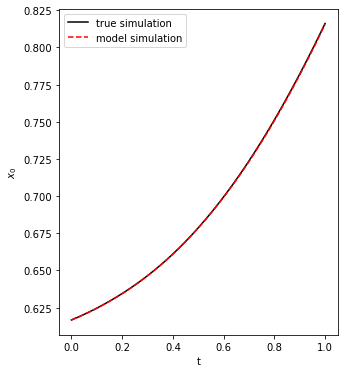

In [ ]:
#dibujo la ec de sindy para ver si son correctas, pruebo con un valor dentro de los de entrenamiento
x_sim = validate(data2_adim[3], t, model, data2_adim[3][0])

print(f"Error: {((x_sim-data2_adim[3])**2).sum() / n}", flush=True)
print(f"Error en el ultimo punto: {((x_sim[-1]-data2_adim[3][-1])**2).sum() / n}")

Model score: 1.000000
Error: 0.9949586365692122
Error en el ultimo punto: 2.3917979670357525e-06


/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


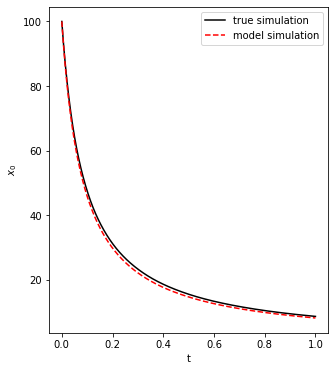

In [37]:
sol = solve_ivp(ecs_dot, (t[0], t[-1]), [100], args=(T0/maxi, A*maxi, B/maxi**3), t_eval=t)

#dibujo la ec de sindy para ver si son correctas, probando con un valor muy grande
x_sim = validate(sol.y.T, t, model, 100)

print(f"Error: {((x_sim-sol.y.T)**2).sum() / n}", flush=True)
print(f"Error en el ultimo punto: {((x_sim[-1]-sol.y.T[-1])**2).sum() / n}")

### Aproximación por Taylor

In [4]:
#definición de las variables generales
n = 100000
deltat = 0.0001
t = np.zeros(n+1)
for i in range(1, n+1):
    t[i] = deltat*i

print(t.shape[0], t)


100001 [0.0000e+00 1.0000e-04 2.0000e-04 ... 9.9998e+00 9.9999e+00 1.0000e+01]


In [5]:
# definicion de parametros fisicos y aerodinamicos de la aeronave
m = 200
W = m*9.81
vx0 = 10
S = 14.7
cd0 = 0.03
k = 0.073
vmax = 6

A = 0.5*1.225*cd0*S/m*10
B = k*9.81**2/(0.5*1.225*S/m)
#Empuje inicial, en este caso va a ser el mismo en todos los tiempos por ser cte
T0 = 7
print(f"Valor real de los coeficientes: A={A}, B={B}, C=T0={T0}")

Valor real de los coeficientes: A=0.013505625, B=156.0513186172428, C=T0=7


In [6]:
#defino la funcion a resolver por el solver:
def ecs_dot(t, y, T0, A, B):
    vx = y
    return T0 - A*vx**2 - B/vx**2
    #return T0 - A*vx**2 - B*3*vx**2 - 8*B*vx + 6*B

In [7]:
#condiciones iniciales generadas para cada trayectoria:
n_trayec = 100
vx0 = np.ones(n_trayec)


for i in range(n_trayec):
    vx0[i] = np.random.uniform(low=5, high=15)
    #vx0[i] = np.random.uniform(low=5, high=100)

    
#vx0[3] = 10
#vx0[2] = 0.1

"""
vx0[1] = 20
vx0[2] = 30
vx0[3] = 40
vx0[4] = 50
"""


'\nvx0[1] = 20\nvx0[2] = 30\nvx0[3] = 40\nvx0[4] = 50\n'

In [8]:
# creo cada trayectoria llamandado a create_glider_data
#las trayectorias son filas mientras que las columnas son caracterisitcas
data2_2 = []

for i in range(n_trayec):
    vx_sol = solve_ivp(ecs_dot, (t[0], t[-1]), [vx0[i]], args=(T0, A, B), t_eval=t)
    data2_2.append(vx_sol.y.T)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


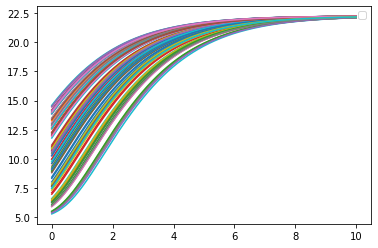

In [9]:
#ploteo los datos para ver la velocidad de cada trayectoria
plt.figure()
for i in range(n_trayec):
    a = data2_2[i]
    plt.plot(t, a[:]) #, label=str(data2[i][0])

plt.legend()

In [10]:
#adimensionalizo buscando el maximo por caracteristica para todas las trayectorias
data2_2_adim = []
maxi = np.max(data2_2, axis=1)
maxi = np.max(maxi, axis=0)
for i in range(n_trayec):
    data2_2_adim.append(data2_2[i] / maxi)
#print(len(data1_adim), data1_adim[0].shape)

In [11]:
maxi = np.max(data2_2, axis=1)
maxi = np.max(maxi, axis=0).item()
maxi

22.214707077674106

In [12]:
def custom_ecs_dim():
    library_functions = [
        #lambda v : v**3,
        lambda v : v**2,
        lambda v: v,
        lambda t: 1
    ]
    library_function_names = [
        #lambda v : v + "^3",
        lambda v : v + "^2",
        lambda v: v, 
        lambda t: "1"
    ]
    library = ps.CustomLibrary(library_functions=library_functions, function_names=library_function_names,
                              interaction_only=True)
    return library

In [13]:
# creo un initial guess para que la primera solucion que encuentre no sea la de todas las ecuaciones = 0
#uso un reshape por el caso de tener un array, pues no tiene dimension de columnas, es posicional

print(data2_2[0].shape, data2_2[0].reshape(-1, 1).shape)
lib = custom_ecs_dim().fit(data2_2[0].reshape(-1, 1))
n_features = lib.n_output_features_
initial_guess = np.ones((data2_2[0].reshape(-1, 1).shape[1], n_features))

initial_guess[0, 0] = 0.7
initial_guess[0, 1] =  -2
initial_guess[0, 2] =  2

print(data2_2[0].reshape(-1, 1).shape[1], n_features)


(100001, 1) (100001, 1)
1 3


In [14]:
library = custom_ecs_dim()
library.fit(data2_2_adim[1])
n_features = library.n_output_features_
print(f"Features ({n_features}):", library.get_feature_names())

# Set constraints
n_targets = data2_2_adim[1].shape[1]
print(n_targets)
constraint_rhs = np.array([-0.1139])

# One row per constraint, one column per coefficient
constraint_lhs = np.zeros((1, n_targets * n_features))


# -1 * (x1_coeff) <= A*maxi -->  1 * (x1_coeff) >= -A*maxi
constraint_lhs[0, 1] = 1

Features (3): ['x0^2', 'x0', '1']
1


In [18]:
model = ps.SINDy(
        #differentiation_method=ps.SINDyDerivative(kind='finite_difference', k=1),
        #optimizer=ps.SR3(initial_guess=initial_guess), #initial_guess=initial_guess
        optimizer=ps.ConstrainedSR3(),
                                    #initial_guess=initial_guess,
        feature_library=ps.PolynomialLibrary(degree=2),#custom_ecs_dim(),
        ##ps.PolynomialLibrary(degree=2)#interaction_only=terminos_ctes,
                                                         
        feature_names=['vx'],
    )

#la doc dice que en t hay que poner el time step
model.fit(data2_2_adim, t=(t[1]-t[0]), multiple_trajectories=True) #
#model.fit(data2_adim[1], t=t[1]-t[0])

#print(model.equations(precision=52))
model.print(precision=4)

(vx)' = 0.6802 vx + -0.6827 vx^2


In [16]:
print(model.get_feature_names())
print(f"Valor real de los coeficientes: A={A}, B={B}, C=T0={T0}")
print(f"Valor que sindy debe obtener: A={A*maxi}, B={B/maxi**3}, C=T0={T0/maxi}")

['1', 'vx', 'vx^2']
Valor real de los coeficientes: A=0.013505625, B=156.0513186172428, C=T0=7
Valor que sindy debe obtener: A=0.3000235032759124, B=0.014234613174353199, C=T0=0.3151065632116768


Model score: 1.000000
Error: 2.522619336584851e-05
Error en el ultimo punto: 7.596921256759205e-11


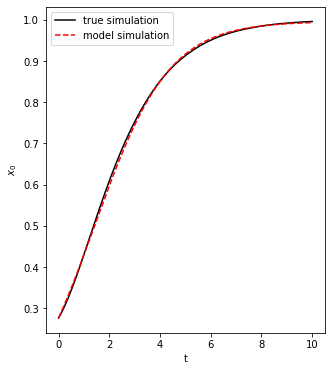

In [111]:
#dibujo la ec de sindy para ver si son correctas, pruebo con un valor dentro de los de entrenamiento
x_sim = validate(data2_2_adim[5], t, model, data2_2_adim[5][0])

print(f"Error: {((x_sim-data2_2_adim[5])**2).sum() / n}", flush=True)
print(f"Error en el ultimo punto: {((x_sim[-1]-data2_2_adim[5][-1])**2).sum() / n}")

In [42]:
data2_2_adim[5][0]

array([0.41609262])

Model score: 1.000000
Error: 19.35596163597874
Error en el ultimo punto: 1.088973829384212e-09


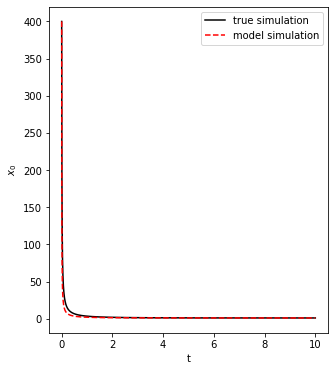

In [43]:
# pruebo con un valor alto, muy alejado de los valores de entrenamiento
v0_test = 400
sol = solve_ivp(ecs_dot, (t[0], t[-1]), [v0_test], args=(T0/maxi, A*maxi, B/maxi**3), t_eval=t)

#dibujo la ec de sindy para ver si son correctas, probando con un valor muy grande
x_sim = validate(sol.y.T, t, model, [v0_test])

print(f"Error: {((x_sim-sol.y.T)**2).sum() / n}", flush=True)
print(f"Error en el ultimo punto: {((x_sim[-1]-sol.y.T[-1])**2).sum() / n}")

Ecuaciones:
$$
L - W\cos{\gamma} = mV\dot{\gamma}\\
T - D - W\sin{\gamma} = m\dot{v}\\
$$
Suponemos $\alpha = 0$:
$$
\frac{1}{2} \rho_{aire} V^{2} S C_{L} = W\cos{\gamma} \\
T - (C_{D0} + kC_{L}^2)\frac{1}{2} \rho_{aire} V^{2}S - W\sin{\gamma} = m\dot{v}\\
C_{L} = C_{L0}\\
$$
Como se puede ver en este caso hay dos variables: gamma y la velocidad. A sindy habrá que alimentar con la ecuacion del eje x, es decir, la segunda.
Además, para velocidades grandes se puede asumir despreciable el término de kcl^2 del coeficiente de resistencia
Sindy será alimentado con la ecuación de la velocidad

In [49]:
#definición de las variables generales
n = 10000
deltat = 0.001
t = np.zeros(n+1)
for i in range(1, n+1):
    t[i] = deltat*i

print(t.shape[0], t)

10001 [0.000e+00 1.000e-03 2.000e-03 ... 9.998e+00 9.999e+00 1.000e+01]


In [50]:
# definicion de parametros fisicos y aerodinamicos de la aeronave
m = 200
W = m*9.81
vx0 = 10
S = 14.7
cd0 = 0.03
k = 0.073
cl0 = 0.05
T0 = 9
A = 0.5*1.225*cd0*S/m
B = m*9.81/m
print(A, B)

0.0013505625 9.81


In [51]:
# la vel de L y D  es la del eje x y no es cte
def create_data_dim_ecs(t, vx0, gamma0, A=A, B=B, T0=T0):
    n = t.shape[0]
    deltat = t[1]-t[0]

    vx = np.zeros(n)
    vx[0] = vx0

    T = T0 * np.ones(n) #esto en realidad es T/m y no T
    #gamma0 está en grados asi que hay que pasarlo a rad
    gamma = gamma0 * np.pi /180 * np.ones(n)

    for i in range(1, n):
        vx[i] = vx[i - 1] + deltat * (T[i-1]-A*vx[i-1]**2 - B*np.sin(gamma[i-1])) 
        


    return np.stack((vx, gamma))

In [52]:
#condiciones iniciales generadas para cada trayectoria:
n_trayec = 50
vx0 = np.ones(n_trayec)
gamma0 = np.ones(n_trayec)


for i in range(n_trayec):
    vx0[i] = np.random.uniform(low=10, high=100)
    gamma0[i] = np.random.uniform(low=1, high=90)

vx0[0] = 100
"""
vx0[1] = 25
vx0[2] = 30
vx0[3] = 40
vx0[4] = 50
vx0[5] = 20
vx0[6] = 6
vx0[7] = 5.5
vx0[8] = 6.5
vx0[9] = 7
"""

'\nvx0[1] = 25\nvx0[2] = 30\nvx0[3] = 40\nvx0[4] = 50\nvx0[5] = 20\nvx0[6] = 6\nvx0[7] = 5.5\nvx0[8] = 6.5\nvx0[9] = 7\n'

In [53]:
# creo cada trayectoria llamandado a create_glider_data
#las trayectorias son filas mientras que las columnas son caracterisitcas
data3 = []

for i in range(n_trayec):
    a = create_data_dim_ecs(t, vx0[i], gamma0[i])
    data3.append(a.T)

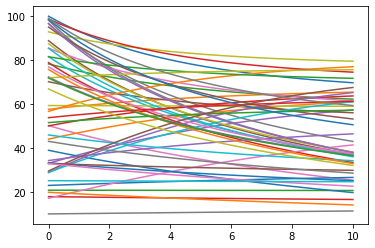

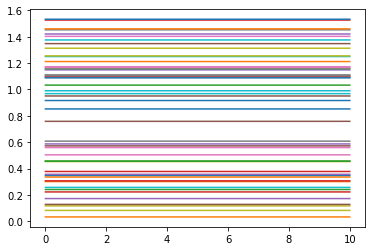

In [54]:
#ploteo los datos para ver la velocidad de cada trayectoria
for j in range(2):
    plt.figure()
    for i in range(n_trayec):
        a = data3[i] #cojo una trayectoria
        plt.plot(t, a[:, j])
        

In [55]:
#adimensionalizo buscando el maximo por caracteristica para todas las trayectorias
data3_adim = []
maxi = np.max(data3, axis=1)
maxi = np.max(maxi, axis=0)
for i in range(n_trayec):
    data3_adim.append(data3[i] / maxi)


In [56]:
maxi = np.max(data3, axis=1)
maxi = np.max(maxi, axis=0)
maxi

array([100.        ,   1.53224744])

In [57]:
def custom_ecs_dim():
    library_functions = [
        lambda v : v**2,
        lambda theta: np.sin(theta),
        lambda cte: 1
    ]
    library_function_names = [
        lambda v : v + "^2",
        lambda theta: 'sin(' + theta + ")", 
        lambda cte: "1"+cte
    ]
    library = ps.CustomLibrary(library_functions=library_functions, function_names=library_function_names,
                              interaction_only=True)
    return library

In [58]:
# creo un initial guess para que la primera solucion que encuentre no sea la de todas las ecuaciones = 0
#uso un reshape por el caso de tener un array, pues no tiene dimension de columnas, es posicional

print(data3[0].shape, data3[0].reshape(-1, 1).shape)
lib = custom_ecs_dim().fit(data3[0])
n_features = lib.n_output_features_
initial_guess = np.ones((data3[0].shape[1], n_features))

initial_guess[0, 0] = -A*maxi[0]
initial_guess[0, 1] =  0
initial_guess[0, 2] =  0
initial_guess[0, 3] = -8/maxi[0]
initial_guess[0, 4] = 10/maxi[0]

print(data3[0].reshape(-1, 1).shape[1], n_features)


(10001, 2) (20002, 1)
1 6


In [59]:
library = custom_ecs_dim()
library.fit(data3_adim[1])
n_features = library.n_output_features_
print(f"Features ({n_features}):", library.get_feature_names())

# Set constraints
n_targets = data3_adim[1].shape[1]
print(n_targets)
constraint_rhs = np.array([-B/maxi[0]]) #, -B/maxi[0]

# One row per constraint, one column per coefficient
constraint_lhs = np.zeros((1, n_targets * n_features))

# 1 * (x1_coeff) <= B/maxi -
constraint_lhs[0, 3] = 1
#constraint_lhs[0, 3] = -1

Features (6): ['x0^2', 'x1^2', 'sin(x0)', 'sin(x1)', '1x0', '1x1']
2


In [60]:
model = ps.SINDy(
        #differentiation_method=ps.SINDyDerivative(kind='finite_difference', k=1),
        optimizer=ps.SR3(initial_guess=initial_guess), #
        #ps.ConstrainedSR3(constraint_rhs=constraint_rhs, constraint_lhs=constraint_lhs,
        #                    initial_guess=initial_guess),
        feature_library=custom_ecs_dim(),
        ##ps.PolynomialLibrary(degree=2)#interaction_only=terminos_ctes,
                                                         
        feature_names=['vx', 'gamma'], #'x', 'y', 'v', 'alfa', 'theta', "theta'"
    )

#la doc dice que en t hay que poner el time step
model.fit(data3_adim, t=deltat, multiple_trajectories=True) #

#print(model.equations(precision=52))
model.print(precision=4)

vx' = -0.1301 vx^2 + -0.1170 sin(gamma) + 0.0405 1vx + 0.0405 1gamma
gamma' = 0.0000


/home/mdiaz/.local/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


In [61]:
model.get_feature_names()

['vx^2', 'gamma^2', 'sin(vx)', 'sin(gamma)', '1vx', '1gamma']

Model score: 1.000000
(2, 1)
[0.88904395 0.87940949]


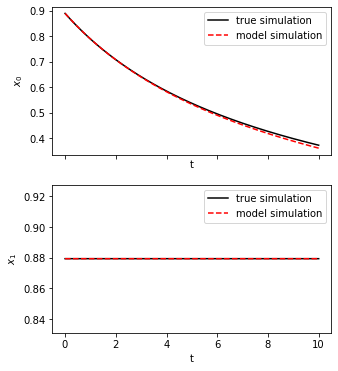

In [62]:
#dibujo la ec de sindy para ver si son correctas
validate(data3_adim[5], t, model, data3_adim[5][0])
print(data3_adim[5][0])

Model score: 0.500000
(2, 1)


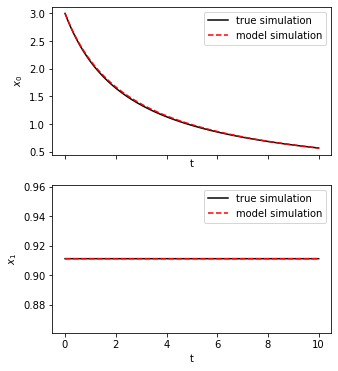

In [63]:
x_real = create_data_dim_ecs(t, 300, 80).T

validate(x_real/maxi , t, model, [300, 80*np.pi/180]/maxi)

Model score: 0.500000
(2, 1)


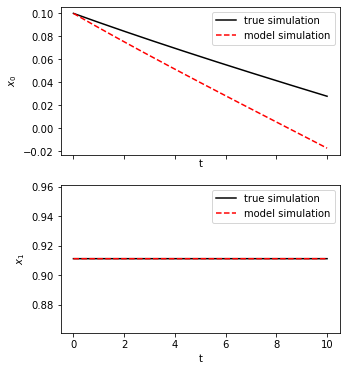

In [64]:
x_real = create_data_dim_ecs(t, 10, 80).T

validate(x_real/maxi , t, model, [10, 80*np.pi/180]/maxi)

con velocidades altas lo hace muy bien porque el ajuste del coeficiente es casi exacto, sin embargo el ajuste del seno y del empuje no es tan aproximado y por ello a velocidades pequeñas se va un poco más, revisar el notebook local con el caso para T/m de 12

$$
\frac{T}{m} - (C_{D0} + kC_{L}^2)\frac{1}{2} \rho_{aire} V^{2}\frac{S}{m} - g\sin{\gamma} = \dot{v}\\
C_{L} = C_{L0} \\
A = C_{D0} \frac{1}{2} \rho_{aire} \frac{S}{m} \\
C = \frac{T}{m} \\
B = g
$$
Si consideramos  v >> 1 entonces el término de cl^2 se anula, pues:
$$
C_{L} = \frac{W\cos{\gamma}}{\frac{1}{2} \rho_{aire} V^{2} S }
$$
Las ecuaciones quedan:
$$
A - B V^{2} - C\sin{\gamma} = \dot{v}\\
$$
Adimensionalizando:
$$
\hat{\dot{V}} =  - C_{D0} \frac{1}{2} \rho_{aire} \hat{\dot{V^2}}U_\infty\frac{S}{m}+ \frac{T}{mU_\infty} - \frac{g\sin{\gamma}}{U_\infty} \\
\hat{\dot{V}} =  - A \hat{\dot{V^2}}U_\infty+ \frac{C}{U_\infty} - \frac{B\sin{\gamma}}{U_\infty} \\
Sindy: \\
a = A U_\infty = 0.1353, A = 0.001353\\
b = \frac{B}{U_\infty}=0.1100, B = 11 \\
c = \frac{C}{U_\infty}= (0.0552*2), C = 11.04 \\
$$


## Turborreactor loop ideal de radio R: alpha no nulo y gamma no cte

### V y gamma variables, empuje CTE

- Para este caso se asume que la variación en la altura es tan pequeña que apenas produce cambio en la densidad
- Al tratarse de un loop ideal, el movimiento es simétrico en el plano vertical y se desarrollará con las alas a nivel
- Hay 3 ecuaciones (2 dinámicas y una angular) y 3 incógnitas (V, alpha y gamma)
$$
L - W\cos{\gamma} = mV\dot{\gamma}\\
\frac{1}{2} \rho_{aire} V^{2} S C_{L}-W\cos{\gamma} = mV\dot{\gamma}\\
---\\
T - D - W\sin{\gamma} = m\dot{V}\\
\frac{T}{m} - (C_{D0} + kC_{L}^2)\frac{1}{2} \rho_{aire} V^{2}\frac{S}{m} - g\sin{\gamma} = \dot{V}\\
---\\
\dot{\gamma} = \frac{V}{R}

$$

- Debido a la complejidad de este caso se usará las variables Cl, V y gamma. Alpha se considera en el cl porque si no hay demasiados términos y sindy no es capaz de calcularlo
- De nuevo, debido a la complejidad se elege un tiempo característico y una velocidad característica con las que adimensionalizar las ecuaciones
- Se define:

$$
\hat{V} = \frac{V}{U}\\
$$

Como son variables adimensionalizas (V y gamma) su derviada debe ser:
$$
\hat{\dot{V}} = \frac{\dot{V}T_c}{U} \\
\hat{\dot{\gamma}} = \dot{\gamma}T_c
$$

Se procede como en los casos anteriores y se adimensionaliza la velocidad:
$$
\frac{\hat{V}\hat{\dot{\gamma}}}{T_C} = \frac{1}{2}\rho \frac{S}{m}C_L U \hat{V}^2 - \frac{g\cos{\gamma}}{U} \\
\frac{\hat{\dot{V}}}{T_C} = \frac{T}{mU} - \frac{1}{2}\rho \frac{S}{m}(C_{D0} + k C_L^2) U \hat{V}^2 - \frac{g\sin{\gamma}}{U} \\
\frac{\hat{\dot{\gamma}}}{T_C} = \hat{V} \frac{U}{R} \\
---
$$
Se multiplican toas las ecuaciones por $T_C$

$$
\hat{V}\hat{\dot{\gamma}} = \frac{1}{2}\rho \frac{S}{m}C_L UT_C \hat{V}^2 - \frac{g\cos{\gamma}}{U}T_C \\
\hat{\dot{V}}= \frac{T}{mU}T_C - \frac{1}{2}\rho \frac{S}{m}(C_{D0} + k C_L^2) U T_C\hat{V}^2 - \frac{g\sin{\gamma}}{U}T_C \\
\hat{\dot{\gamma}} = \hat{V} \frac{U}{R}T_C \\

$$



Se asingan coeficientes:

$$
A_1 = \frac{1}{2}\rho\frac{S}{m}UT_C \\
A_2 = T_C\frac{g}{U} \\
A_3 = \frac{T}{mU}T_C \\
A_4 = T_C\frac{U}{R} \\
$$
Se eligen:
$$
T_c = \frac{U}{g} \\
U=\sqrt{\frac{2gm}{S\rho}}
$$ 
Los coeficientes quedarían:
$$
A_1 = 1; A_2 = 1; A_3 = \frac{T}{mg}; A_4 = \frac{2m}{\rho S R}
$$
Las ecuaciones:
$$
\hat{V}^2 C_L - \cos{\gamma} = \hat{V}\hat{\dot{\gamma}} \\
A_3 - (c_{D0} + kC_L^2) \hat{V}^2 - \sin{\gamma} = \hat{\dot{V}} \\
\hat{\dot{\gamma}} = A_4 \hat{V}
$$


Se sustituye la tercera ecuación en la primera y se despejando el $C_L$:
$$
C_L = \frac{\hat{V}\hat{\dot{\gamma}}}{\hat{V}^2} + \frac{\cos{\gamma}}{\hat{V}^2}
$$
Se sustituye el $C_L$ en la segunda ecuación, el sistema final que se obtiene es:
$$
A_3 - (cd_0 + kA_4^2)\hat{V}^2 - 2kA_4\cos{\gamma} - \sin{\gamma} - \frac{k(\cos{\gamma})^2}{\hat{V}^2} = \hat{\dot{V}} \\
\hat{\dot{\gamma}} = A_4 \hat{V}

Sindy debe obtener las siguientes ecuaciones:
$$
A_3 - A_5\hat{V}^2 - A_6\cos{\gamma} - A_7\sin{\gamma} - \frac{A_8(\cos{\gamma})^2}{\hat{V}^2} = \hat{\dot{V}} \\
\hat{\dot{\gamma}} = A_4 \hat{V}
$$
Donde:
$$
A_3 = \frac{T}{mg} \\
A_4 = \frac{2m}{\rho S R} \\
A_5 = cd_0 + kA_4^2 \\
A_6 = 2kA_4 \\
A_7 = 1 \\
A_8 = k \\

In [27]:
#definición de las variables generales
n = 10000
deltat = 0.001
t = np.zeros(n+1)
for i in range(1, n+1):
    t[i] = deltat*i

print(t.shape[0], t)

10001 [0.000e+00 1.000e-03 2.000e-03 ... 9.998e+00 9.999e+00 1.000e+01]


In [28]:
# definicion de parametros fisicos y aerodinamicos de la aeronave
m = 200
W = m*9.81
vx0 = 10
S = 14.7
cd0 = 0.03
k = 0.073

T0 = 12 # T/m

R = 70
# velocidad caracteristica
U = (2*9.81*m/(1.225*S))**0.5
Tc = U/9.81
A1 = 0.5*1.225*U*Tc*S/m
A2 = Tc*9.81/U
A3 = T0*Tc/(U)
A4 = Tc*U/(R)
A5 = cd0 + k*A4**2
A6 = 2*k*A4
A7 = 1
A8 = k
print(f"Valor de los coeficientes: A1={A1}, A2={A2}, A3={A3}, A4={A4}, U={U}, Tc={Tc}")
print(f"Valores que sindy debe obtener: A3={A3}, A4={A4}, A5={A5}, A6={A6}, A7={A7}, A8={A8}")


Valor de los coeficientes: A1=0.9999999999999999, A2=1.0, A3=1.2232415902140672, A4=0.3173280974197259, U=14.76174801634704, Tc=1.5047653431546422
Valores que sindy debe obtener: A3=1.2232415902140672, A4=0.3173280974197259, A5=0.037350889863077684, A6=0.04632990222327998, A7=1, A8=0.073


In [29]:
# la vel de L y D  es la del eje x y no es cte
def create_data_dim_ecs(t, v0, gamma0, cd0=cd0, k=k):
    n = t.shape[0]
    deltat = t[1]-t[0]

    v = np.zeros(n)
    v[0] = v0

    #gamma0 está en grados asi que hay que pasarlo a rad
    gamma = np.zeros(n)
    gamma[0] = gamma0 * np.pi /180
    
    v_dot = np.zeros(n)
    gamma_dot = np.zeros(n)

    v_dot[0] = (A3 - (cd0 + k*A4**2)*v0**2 - 2*k*A4*np.cos(gamma0) 
                    - np.sin(gamma0) - k*np.cos(gamma0)**2/v0**2)
    gamma_dot[0] = v0*A4


    for i in range(1, n):
        v[i] = v[i - 1] + deltat * (A3 - (cd0 + k*A4**2)*v[i - 1]**2 - 2*k*A4*np.cos(gamma[i-1]) 
                    - np.sin(gamma[i - 1]) - k*np.cos(gamma[i-1])**2/v[i - 1]**2)
        gamma[i] = gamma[i-1] + A4 * v[i - 1]* deltat
        
        
        v_dot[i] = (A3 - (cd0 + k*A4**2)*v[i]**2 - 2*k*A4*np.cos(gamma[i]) 
                    - np.sin(gamma[i]) - k*np.cos(gamma[i])**2/v[i]**2)
        gamma_dot[i] = v[i]*A4
        
        #print("cl:"+str(cl[i]), "gamma:"+str(gamma[i]))
    """ p_n = 0.1
    v += np.sqrt(p_n)*np.random.randn(n)
    gamma += np.sqrt(p_n)*np.random.randn(n) """
    
    return np.stack((v, gamma)), np.stack((v_dot, gamma_dot))

In [30]:
#condiciones iniciales generadas para cada trayectoria:
n_trayec = 20
v0 = np.ones(n_trayec)
gamma0 = np.ones(n_trayec)
alpha0 = np.ones(n_trayec)


for i in range(n_trayec):
    #vz0[i] = np.random.uniform(low=25, high=30)
    v0[i] = np.random.uniform(low=30, high=100)
    gamma0[i] = np.random.uniform(low=10, high=360)

#v0[0] = 100
#v0[1] = 25
#v0[2] = 30
#v0[3] = 40
v0[4] = 50
"""
vz0[0] = 1
vz0[1] = 2
vz0[2] = 3
vz0[3] = 3.5
vz0[4] = 5
"""

'\nvz0[0] = 1\nvz0[1] = 2\nvz0[2] = 3\nvz0[3] = 3.5\nvz0[4] = 5\n'

In [31]:
# creo cada trayectoria llamandado a create_data_dim_ecs
#las trayectorias son filas mientras que las columnas son caracterisitcas
data4 = []
data4_dot = []

for i in range(n_trayec):
    a, b = create_data_dim_ecs(t, v0[i], gamma0[i])
    data4.append(a.T)
    data4_dot.append(b.T)

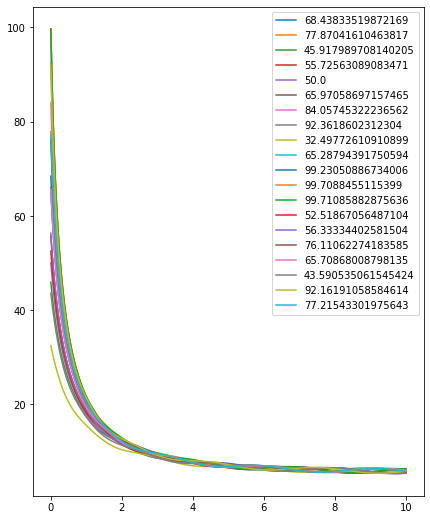

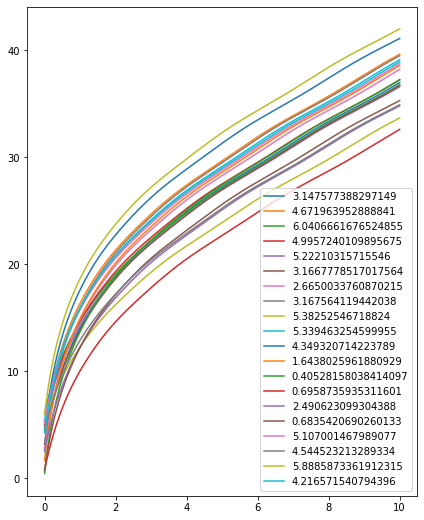

In [32]:
#ploteo los datos para ver la velocidad de cada trayectoria
for j in range(2):
    plt.figure(figsize=(7, 9))
    for i in range(n_trayec):
        a = data4[i] #cojo una trayectoria
        plt.plot(t, a[:, j], label=str(a[0, j]))
        plt.legend()

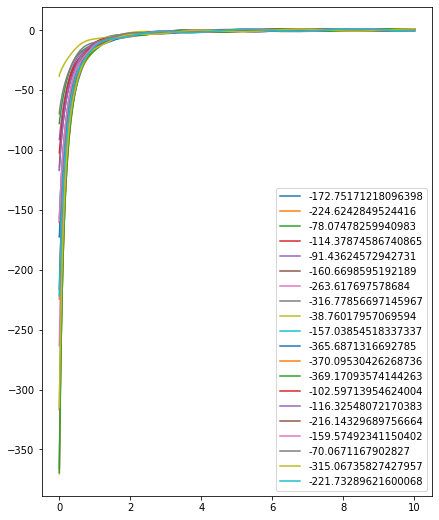

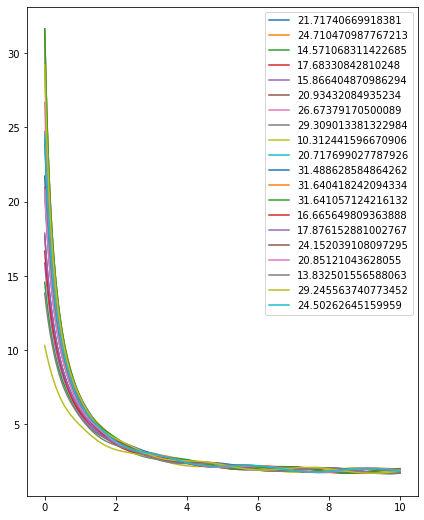

In [33]:
#ploteo los datos de las derivadas
for j in range(2):
    plt.figure(figsize=(7, 9))
    for i in range(n_trayec):
        a = data4_dot[i] #cojo una trayectoria
        plt.plot(t, a[:, j], label=str(a[0, j]))
        plt.legend()

In [34]:
def custom_ecs_dim():
    library_functions = [
        lambda v : v,
        lambda v : v**2,
        lambda theta: np.sin(theta),
        lambda theta: np.cos(theta),
        lambda v, theta: np.cos(theta)**2/v**2,
        #lambda v: 1/v**2,
        #lambda v: 1/v**3,
        lambda cte: 1
    ]
    library_function_names = [
        lambda v : v,
        lambda v : v + "^2",
        lambda theta: 'sin(' + theta + ")", 
        lambda theta: 'cos(' + theta + ")",
        lambda v, theta: 'cos(' + theta + ")^2" + '/' + v + "^2",
        #lambda v: '1/' + v + "^2",
        #lambda v: '1/' + v + "^3",
        lambda cte: "1"+cte
    ]
    library = ps.CustomLibrary(library_functions=library_functions, function_names=library_function_names,
                              interaction_only=True)
    return library

In [35]:
print(data4[0].shape, data4[0].reshape(-1, 1).shape)
lib = custom_ecs_dim().fit(data4[0])
n_features = lib.n_output_features_
list_names = lib.get_feature_names(['v', 'gamma'])
print(list_names)

(10001, 2) (20002, 1)
['v', 'gamma', 'v^2', 'gamma^2', 'sin(v)', 'sin(gamma)', 'cos(v)', 'cos(gamma)', 'cos(gamma)^2/v^2', '1v', '1gamma']


In [36]:
# creo un initial guess para que la primera solucion que encuentre no sea la de todas las ecuaciones = 0
#uso un reshape por el caso de tener un array, pues no tiene dimension de columnas, es posicional

initial_guess = np.zeros((data4[0].shape[1], n_features))
"""
initial_guess[0, 0] = 1
initial_guess[0, 1] =  0
initial_guess[0, 2] =  0
initial_guess[0, 3] = 1
initial_guess[0, 4] = 32
"""

initial_guess[0, list_names.index('1gamma')] = 10
initial_guess[0, list_names.index('v^2')] = 10
initial_guess[0, list_names.index('cos(gamma)^2/v^2')] = k*10
initial_guess[0, list_names.index('cos(gamma)')] = 10
initial_guess[0, list_names.index('sin(gamma)')] = 10

initial_guess[1, list_names.index('v')] = 10



print(data4[0].reshape(-1, 1).shape[1], n_features)


1 11


In [37]:
print(list_names)

# Set constraints
n_targets = data4[1].shape[1]
print(n_targets)
constraint_rhs = np.array([-A8*10]) #, -B/maxi[0]

# One row per constraint, one column per coefficient
constraint_lhs = np.zeros((1, n_targets * n_features))

# 1 * (x1_coeff) <= 0
#constraint_lhs[0, list_names.index('v')] = 1
#constraint_lhs[0, list_names.index('cos(gamma)^2/v^2')] = -1

constraint_lhs[0, list_names.index('cos(gamma)^2/v^2')] = 1

#constraint_lhs[2, n_features+list_names.index('v')] = 1

#constraint_lhs[0, 3] = -1

['v', 'gamma', 'v^2', 'gamma^2', 'sin(v)', 'sin(gamma)', 'cos(v)', 'cos(gamma)', 'cos(gamma)^2/v^2', '1v', '1gamma']
2


In [39]:
model = ps.SINDy(
        #differentiation_method=ps.SINDyDerivative(kind='finite_difference', k=1),
        #optimizer=ps.SR3(initial_guess=initial_guess), #
        optimizer=ps.ConstrainedSR3(#constraint_rhs=constraint_rhs, constraint_lhs=constraint_lhs,
                          initial_guess=initial_guess),
        feature_library=custom_ecs_dim(),
        ##ps.PolynomialLibrary(degree=2)#interaction_only=terminos_ctes,
                                                         
        feature_names=['v','gamma'], #'x', 'y', 'v', 'alfa', 'theta', "theta'"
    )

#la doc dice que en t hay que poner el time step
deltat_new = 0.0001
model.fit(data4, t=deltat_new, multiple_trajectories=True) 
#print(model.equations(precision=52))
model.print(precision=4)

(v)' = -0.3744 v^2 + -10.0037 sin(gamma) + -0.4506 cos(gamma) + -5.8644 cos(gamma)^2/v^2 + 6.1866 1v + 6.1866 1gamma
(gamma)' = 3.1753 v


In [40]:
model.get_feature_names()
print(f"Valor de los coeficientes: A1={A1}, A2={A2}, A3={A3}, A4={A4}, U={U}, Tc={Tc}")
# como se usa otro deltat al alimentar a sindy se obtienen los coeficientes escalados:
rel = deltat/deltat_new
print(f"Valores que sindy debe obtener: A3={A3}, A4={A4}, A5={A5}, A6={A6}, A7={A7}, A8={A8}")
print(f"Valores que sindy debe obtener con rel: A3={A3*rel}, A4={A4*rel}, A5={A5*rel}, \
        A6={A6*rel}, A7={A7*rel}, A8={A8*rel}")

Valor de los coeficientes: A1=0.9999999999999999, A2=1.0, A3=1.2232415902140672, A4=0.3173280974197259, U=14.76174801634704, Tc=1.5047653431546422
Valores que sindy debe obtener: A3=1.2232415902140672, A4=0.3173280974197259, A5=0.037350889863077684, A6=0.04632990222327998, A7=1, A8=0.073
Valores que sindy debe obtener con rel: A3=12.232415902140673, A4=3.173280974197259, A5=0.37350889863077685,         A6=0.4632990222327998, A7=10.0, A8=0.73


10.0 1.0
Model score: 1.000000
Error[6.76320233e-05 1.94786191e-04]
Error en el ultimo punto: 9.263965834129791e-08


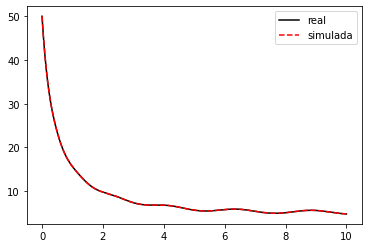

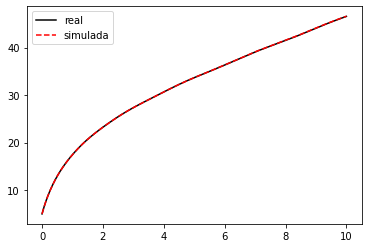

In [20]:
#dibujo la ec de sindy para ver si son correctas con valores en la matriz de train
n_new = 10000
deltat_new = 0.0001
t_new = np.zeros(n_new+1)
for i in range(1, n_new+1):
    t_new[i] = deltat_new*i
print(t[-1], t_new[-1])

x_sim = model.simulate(data4[4][0], t_new)
print('Model score: %f' % model.score(x_sim, t=deltat_new))
print(f"Error{((x_sim-data4[4])**2).sum(axis=0) / n}")
print(f"Error en el ultimo punto: {((x_sim[-1]-data4[4][-1])**2).sum() / n}")

#ploteo los datos para ver las trayectorias
for j in range(2):
    plt.figure()
    plt.plot(t, data4[4][:, j], 'k', label='real') 
    plt.plot(t, x_sim[:, j], 'r--', label='simulada')
    plt.legend()

10.0 1.0
Error[0.00011307 0.00015768]
Model score: 1.000000
Error en el ultimo punto: 1.0507025539600452e-08
(10001, 2)


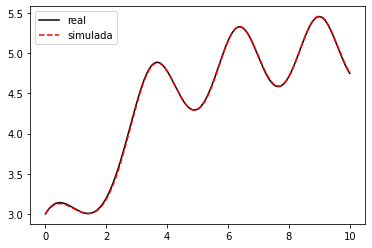

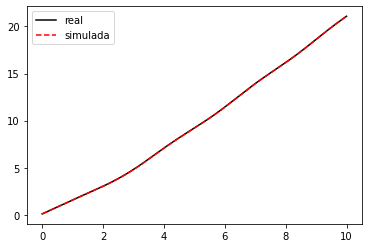

In [33]:
#dibujo la ec de sindy para ver si son correctas con valores en la matriz de train
n_new = 10000
deltat_new = 0.0001
t_new = np.zeros(n_new+1)
for i in range(1, n_new+1):
    t_new[i] = deltat_new*i
print(t[-1], t_new[-1])

v0_sim = 3
x_sim = model.simulate([v0_sim,0.0872], t_new)
x_real, x_dot_real = create_data_dim_ecs(t, v0_sim, 5)
print(f"Error{((x_sim-x_real.T)**2).sum(axis=0) / n}")
print('Model score: %f' % model.score(x_sim, t=deltat_new))
print(f"Error en el ultimo punto: {((x_sim[-1]-x_real.T[-1])**2).sum() / n}")

print(x_sim.shape)
#ploteo los datos para ver las trayectorias
for j in range(2):
    plt.figure()
    plt.plot(t, x_real.T[:, j], 'k', label='real') 
    plt.plot(t, x_sim[:, j], 'r--', label='simulada')
    plt.legend()

### Empuje y gamma variables, V cte

- Para este caso se asume que la variación en la altura es tan pequeña que apenas produce cambio en la densidad
- Al tratarse de un loop ideal, el movimiento es simétrico en el plano vertical y se desarrollará con las alas a nivel
- Hay 3 ecuaciones (2 dinámicas y una angular) y 3 incógnitas (T, alpha y gamma)
$$
L - W\cos{\gamma} = mV_0\dot{\gamma}\\
\frac{1}{2} \rho_{aire} V^{2} S C_{L} - W\cos{\gamma} = mV_0\dot{\gamma}\\
---\\
T - D - W\sin{\gamma} = m\dot{V} = 0\\
T - (C_{D0} + kC_{L}^2)\frac{1}{2} \rho_{aire} V_0^{2}S - W\sin{\gamma} = 0\\
T = (C_{D0} + kC_{L}^2)\frac{1}{2} \rho_{aire} V_0^{2}S + W\sin{\gamma}\\
---\\
\dot{\gamma} = \frac{V_0}{R}

$$

- Debido a la complejidad de este caso se usará las variables Cl, V y gamma. Alpha se considera dependendiente del cl, si no hay demasiados términos y sindy no es capaz de calcularlo

- Se despeja el cl de la primera ecuación:

$$
C_L = \frac{2}{\rho_{aire} S V_0^2}(W \cos{\gamma} + m \frac{V_0^2}{R})\\
$$

Se sustituye en la segunda ecuación:
$$
T = \frac{1}{2} S\rho_{aire} V_0^{2}C_{D0} + \frac{2k}{S\rho_{aire} V_0^{2}} (W^2 (\cos{\gamma})^2 + m^2\frac{V_0^4}{R^2} + \frac{2WmV_0^2}{R}\cos{\gamma}) + W\sin{\gamma}\\
\dot{\gamma} = \frac{V_0}{R}
$$

Definiendo:

$$
A_1 = \frac{1}{2} S\rho_{aire} V_0^{2}  \\
A_2 = A_1 C_{D0} \\
A_3 = \frac{k}{A_1} \frac{m^2V_0^4}{R^2} = \frac{2km^2V_0^2}{\rho S R^2} \\
A_4 = \frac{k}{A_1} W^2 = \frac{2kW^2}{\rho S V_0^2} \\
A_5 = \frac{k}{A_1} \frac{2WmV_0^2}{R} = \frac{4kWm}{\rho S R} \\
A_6 = \frac{V_0}{R} \\
A_7 = A_2 + A_3

$$

Por tanto, las ecuaciones son las siguientes:

$$
T = A_7  + A_4(\cos{\gamma})^2 + A_5\cos{\gamma} + W\sin{\gamma}  \\
\dot{\gamma} = A_6 
$$

Sindy debe obtener las siguientes ecuaciones en derivadas:
$$
\dot{T} = -2A_4\frac{V_0}{R}\cos{\gamma}\sin{\gamma} - A_5\frac{V_0}{R}\sin{\gamma} + W\frac{V_0}{R}\cos{\gamma} \\
\dot{T} = -A_4\frac{V_0}{R}\sin{2\gamma} - A_5\frac{V_0}{R}\sin{\gamma} + W\frac{V_0}{R}\cos{\gamma} \\
\dot{\gamma} = A_6 
$$

Si se define:
$$
A_6 = \frac{V_0}{R} \\
A_8 = A_4\frac{V_0}{R} \\
A_9 = A_5\frac{V_0}{R} \\
A_{10} = W\frac{V_0}{R}
$$
Sindy debe predecir:
$$
\dot{T} = -A_8\sin{2\gamma} - A_9\sin{\gamma} + A_{10}\cos{\gamma} \\
\dot{\gamma} = A_6 
$$

In [3]:
#definición de las variables generales
n = 10000
deltat = 0.001
t = np.zeros(n+1)
for i in range(1, n+1):
    t[i] = deltat*i

print(t.shape[0], t)

10001 [0.000e+00 1.000e-03 2.000e-03 ... 9.998e+00 9.999e+00 1.000e+01]


In [4]:
# definicion de parametros fisicos y aerodinamicos de la aeronave
m = 100
W = m*9.81
vx0 = 10
S = 14.7
cd0 = 0.03
k = 0.073

V0 = 10
R = 100
# velocidad caracteristica
U = (2*9.81*m/(1.225*S))**0.5
Tc = U/9.81
A1 = 0.5*1.225*S*V0**2
A2 = A1*cd0
A3 = (k*m**2 * V0**4)/(A1*R**2)
A4 = k*W**2/A1
A5 = (2*k*W*m*V0**2)/(R*A1)
A6 = V0/R*10
A7 = A2 + A3
A8 = A4*V0/R
A9 = A5*V0/R
A10 = W*V0/R
print(f"Valor de los coeficientes: A4={A4}, A5={A5}, A6={A6}, A7={A7}, W={W}")
print(f"Coeficientes que sindy debe calcular: A6={A6}, A8={A8}, A9={A9}, A10={A10}")


Valor de los coeficientes: A4=78.02565930862141, A5=15.907371928363181, A6=1.0, A7=27.8220232889074, W=981.0
Coeficientes que sindy debe calcular: A6=1.0, A8=7.802565930862142, A9=1.590737192836318, A10=98.1


In [5]:
# la vel de L y D  es la del eje x y no es cte
def create_data_dim_ecs(t, gamma0, T0):
    n = t.shape[0]
    deltat = t[1]-t[0]

    T = np.zeros(n)
    #T[0] = A7 + A4 + A5
    #T[0] = A10
    T0 = T0

    #gamma0 está en grados asi que hay que pasarlo a rad
    gamma = np.zeros(n)
    gamma[0] = gamma0 * np.pi /180
    
    T_dot = np.zeros(n)
    T_dot[0] = A10
    gamma_dot = np.ones(n)*A6


    for i in range(1, n):
        gamma[i] = gamma[i-1] + A6 * deltat
        #T[i] = A7 + + A4*np.cos(gamma[i])**2 + A5*np.cos(gamma[i]) + W*np.sin(gamma[i])

        T[i] = T[i-1] + deltat*(A10*np.cos(gamma[i-1]) - A9*np.sin(gamma[i-1]) - A8*np.sin(2*gamma[i-1])) 
        T_dot[i] = A10*np.cos(gamma[i]) - A9*np.sin(gamma[i]) - A8*np.sin(2*gamma[i]) 
        
        
        #print("cl:"+str(cl[i]), "gamma:"+str(gamma[i]))
    """ p_n = 0.1
    v += np.sqrt(p_n)*np.random.randn(n)
    gamma += np.sqrt(p_n)*np.random.randn(n) """
    
    return np.stack((T, gamma)), np.stack((T_dot, gamma_dot))

In [6]:
#condiciones iniciales generadas para cada trayectoria:
n_trayec = 10
T0 = np.ones(n_trayec)
gamma0 = np.ones(n_trayec)


for i in range(n_trayec):
    T0[i] = np.random.uniform(low=20, high=50)
    gamma0[i] = np.random.uniform(low=10, high=360)


In [7]:
# creo cada trayectoria llamandado a create_data_dim_ecs
#las trayectorias son filas mientras que las columnas son caracterisitcas
data4_1 = []
data4_1_dot = []

for i in range(n_trayec):
    a, b = create_data_dim_ecs(t, gamma0[i], T0[i])
    data4_1.append(a.T)
    data4_1_dot.append(b.T)

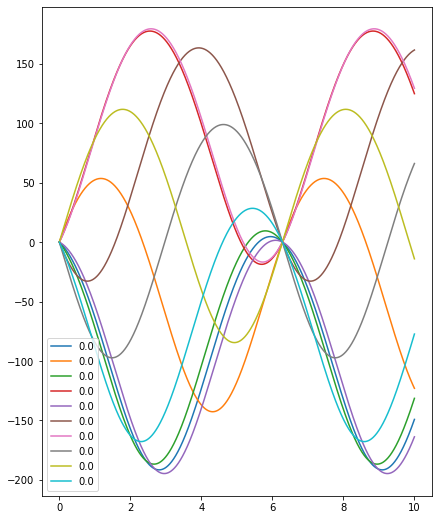

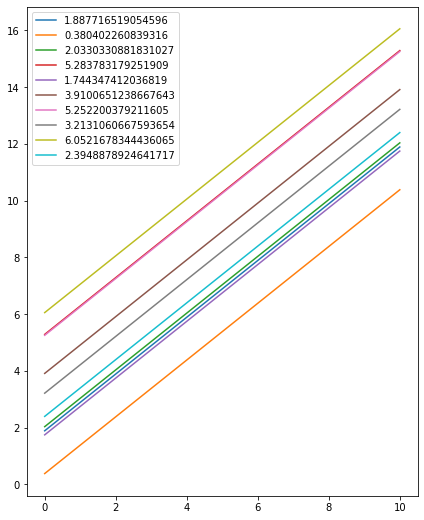

In [8]:
#ploteo los datos para ver el empuje y gamma de cada trayectoria
for j in range(2):
    plt.figure(figsize=(7, 9))
    for i in range(n_trayec):
        a = data4_1[i] #cojo una trayectoria
        plt.plot(t, a[:, j], label=str(a[0, j]))
        plt.legend()

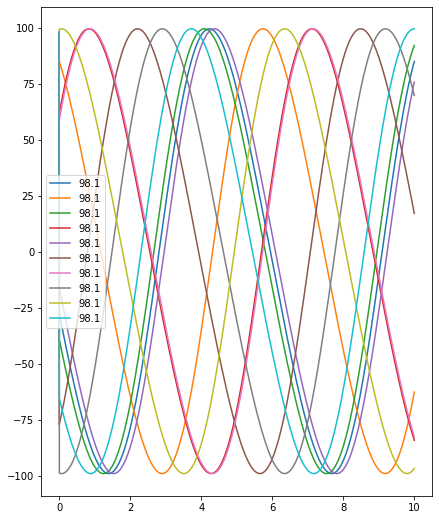

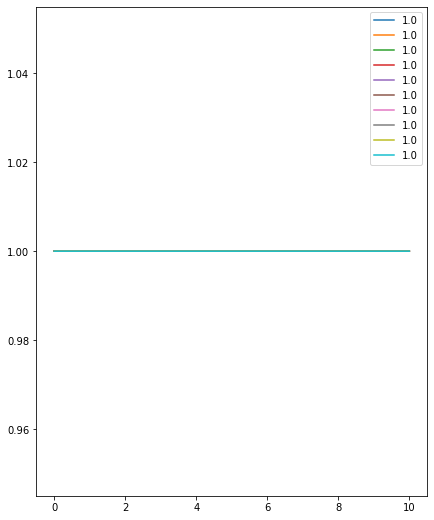

In [9]:
#ploteo los datos de las derivadas
for j in range(2):
    plt.figure(figsize=(7, 9))
    for i in range(n_trayec):
        a = data4_1_dot[i] #cojo una trayectoria
        plt.plot(t, a[:, j], label=str(a[0, j]))
        plt.legend()

In [10]:
data4_1_adim = []
data4_1_adim_dot = []

maxi = np.max(data4_1, axis=1)
maxi = np.max(maxi, axis=0)

print(maxi)
#maxi[1] = 1

for traye in range(n_trayec):
    data4_1_adim.append(data4_1[traye] / maxi)
    data4_1_adim_dot.append(data4_1_dot[traye] / maxi)


data4_1_adim[0]


[179.41659871  16.05216783]


array([[ 0.00000000e+00,  1.17598853e-01],
       [-1.53065775e-04,  1.17661149e-01],
       [-3.06578210e-04,  1.17723446e-01],
       ...,
       [-8.32244204e-01,  7.40443075e-01],
       [-8.31771156e-01,  7.40505372e-01],
       [-8.31297790e-01,  7.40567669e-01]])

In [11]:
def custom_ecs_dim():
    library_functions = [
        lambda theta: np.sin(2*theta),
        lambda theta: np.sin(theta),
        lambda theta: np.cos(theta),
        lambda cte: 1
    ]
    library_function_names = [
        
        lambda theta: 'sin(2*' + theta + ")", 
        lambda theta: 'sin(' + theta + ")", 
        lambda theta: 'cos(' + theta + ")",
        lambda cte: "1"
    ]
    library = ps.CustomLibrary(library_functions=library_functions, function_names=library_function_names,
                              interaction_only=True)
    return library

In [12]:
print(data4_1[0].shape[1], data4_1[0].reshape(-1, 1).shape)
lib = custom_ecs_dim().fit(data4_1[0])
n_features = lib.n_output_features_
list_names = lib.get_feature_names(['T', 'gamma'])
print(list_names)

2 (20002, 1)
['sin(2*T)', 'sin(2*gamma)', 'sin(T)', 'sin(gamma)', 'cos(T)', 'cos(gamma)', '1', '1']


In [13]:
# creo un initial guess para que la primera solucion que encuentre no sea la de todas las ecuaciones = 0
#uso un reshape por el caso de tener un array, pues no tiene dimension de columnas, es posicional

initial_guess = np.zeros((data4_1_adim[0].shape[1], n_features))

initial_guess[0, list_names.index('sin(gamma)')] = 1
initial_guess[0, list_names.index('sin(2*gamma)')] = 1
initial_guess[0, list_names.index('cos(gamma)')] = 100

#initial_guess[1, list_names.index('1T')] = 0.1
#initial_guess[1, list_names.index('1gamma')] = 0.1

print(data4_1_adim[0].reshape(-1, 1).shape[1], n_features)


1 8


In [22]:

model = ps.SINDy(
        #differentiation_method=ps.SINDyDerivative(kind='finite_difference', k=1),
        #optimizer=ps.SR3(initial_guess=initial_guess), #
        optimizer=ps.ConstrainedSR3(#constraint_rhs=constraint_rhs, constraint_lhs=constraint_lhs,
                          initial_guess=initial_guess),
        feature_library=custom_ecs_dim(),
        ##ps.PolynomialLibrary(degree=2)#interaction_only=terminos_ctes,
                                                         
        feature_names=['T','gamma'], 
    )

#la doc dice que en t hay que poner el time step
deltat_new = 0.0001
#model.fit(data4, t=deltat_new, multiple_trajectories=True) 
model.fit(data4_1, t=deltat, multiple_trajectories=True) 

#print(model.equations(precision=52))
model.print(precision=4)

# como se puede ver en este caso adimensionalizar no ayuda

(T)' = -7.8025 sin(2*gamma) + -1.5415 sin(gamma) + 98.1006 cos(gamma)
(gamma)' = 0.4319 1 + 0.5681 1


In [15]:
model.get_feature_names()
#print(f"Valor de los coeficientes: A1={A1}, A2={A2}, A3={A3}, A4={A4}, U={U}, Tc={Tc}")
# como se usa otro deltat al alimentar a sindy se obtienen los coeficientes escalados:
rel = deltat/deltat_new
#print(f"Valor de los coeficientes: A1={A1*rel}, A2={A2*rel}, A3={A3*rel}, A4={A4*rel}, U={U*rel}, Tc={Tc*rel}")
print(f"Coeficientes que sindy debe calcular: A6={A6}, A8={A8}, A9={A9}, A10={A10}")

Coeficientes que sindy debe calcular: A6=1.0, A8=7.802565930862142, A9=1.590737192836318, A10=98.1


Model score: 0.449434
Error[8.52935256e-06 6.18106494e-24]
Error en el ultimo punto: 7.146604224064344e-10


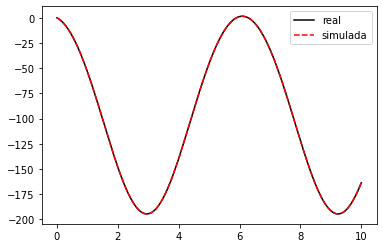

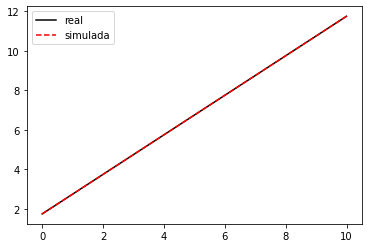

In [16]:
#dibujo la ec de sindy para ver si son correctas con valores en la matriz de train

x_sim = model.simulate(data4_1[4][0], t)
print('Model score: %f' % model.score(x_sim, t=deltat))
print(f'Error{((x_sim-data4_1[4])**2).sum(axis=0) / n}')
print(f"Error en el ultimo punto: {((x_sim[-1]-data4_1[4][-1])**2).sum() / n}")
#ploteo los datos para ver las trayectorias
for j in range(2):
    plt.figure()
    plt.plot(t, data4_1[4][:, j], 'k', label='real') 
    plt.plot(t, x_sim[:, j], 'r--', label='simulada')
    plt.legend()

Error[2.50789867e+01 4.41771918e-09]
Model score: 0.478838
Error en el ultimo punto: 0.0025093661567805424


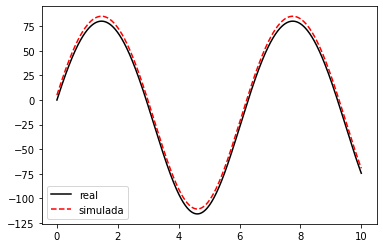

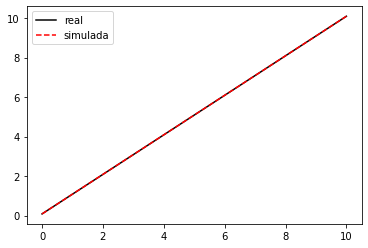

In [17]:
#dibujo la ec de sindy para ver si son correctas con valores en la matriz de train

T0_sim = 5
x_sim = model.simulate([T0_sim,0.0872], t)
x_real, x_dot_real = create_data_dim_ecs(t, T0_sim, 5)

print(f'Error{((x_sim-x_real.T)**2).sum(axis=0) / n}')
print('Model score: %f' % model.score(x_sim, t=deltat))
print(f"Error en el ultimo punto: {((x_sim[-1]-x_real.T[-1])**2).sum() / n}")

#ploteo los datos para ver las trayectorias
for j in range(2):
    plt.figure()
    plt.plot(t, x_real.T[:, j], 'k', label='real') 
    plt.plot(t, x_sim[:, j], 'r--', label='simulada')
    plt.legend()